# Metric Testing
Construct custom network and test [defined metrics](../docs/30Oct18.md).

Then construct larger sample network and test metrics.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## Sample Network From Persistence Paper (Matinelli et al.)

### Network

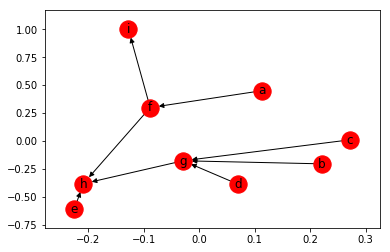

In [2]:
# network where link represents relation R, where x R y implies that y cites x
G = nx.DiGraph()
G.add_nodes_from(['a','b','c','d','e','f','i','g','h'])
G.add_edges_from([('a','f'),('f','i'),('f','h'),('b','g'),('c','g'),('d','g'),('e','h'),('g','h')])
nx.draw_networkx(G, pos=nx.spring_layout(G))

### Weighting Indices
Calculate the weighting indices for each node in the network.

#### Quality Indicators
- Forward cites
- Backward cites
- Claims
- Family size

In [3]:
in_degrees = {node: int(in_degree*(len(G)-1)) for node, in_degree in nx.out_degree_centrality(G).items()}

nx.set_node_attributes(G, in_degrees, 'forward_cites')
[(node, G.nodes[node]['forward_cites']) for node in G]

[('a', 1),
 ('b', 1),
 ('c', 1),
 ('d', 1),
 ('e', 1),
 ('f', 2),
 ('i', 0),
 ('g', 1),
 ('h', 0)]

In [4]:
in_degrees = {node: int(in_degree*(len(G)-1)) for node, in_degree in nx.in_degree_centrality(G).items()}

nx.set_node_attributes(G, in_degrees, 'backward_cites')
[(node, G.nodes[node]['backward_cites']) for node in G]

[('a', 0),
 ('b', 0),
 ('c', 0),
 ('d', 0),
 ('e', 0),
 ('f', 1),
 ('i', 1),
 ('g', 3),
 ('h', 3)]

In [5]:
# Placeholder values for family size
family_size = {node: int(np.random.normal(3,2)) for node in G}

nx.set_node_attributes(G, family_size, 'family_size')
[(node, G.nodes[node]['family_size']) for node in G]

[('a', 2),
 ('b', 6),
 ('c', 1),
 ('d', 6),
 ('e', 1),
 ('f', 3),
 ('i', 4),
 ('g', 3),
 ('h', 0)]

In [6]:
# Placeholder values for claims
num_claims = {node: int(np.random.normal(2.5, 0.5)) for node in G}
nx.set_node_attributes(G, num_claims, 'num_claims')

[(node, G.nodes[node]['num_claims']) for node in G]

[('a', 2),
 ('b', 2),
 ('c', 3),
 ('d', 2),
 ('e', 2),
 ('f', 2),
 ('i', 1),
 ('g', 2),
 ('h', 2)]

#### H-index
The h-index of a given node is the h-index of its forward citations.

In [7]:
# h-index calculation
def h_index(m):
    s = [0]*(len(m)+1)
    for i in range(len(m)):
        s[min([len(m), m[i]])] += 1
    x = 0
    for i in reversed(range(len(s))):
        x += s[i]
        if x >= i:
            return i
    return 0

In [8]:
h_indices = {}
for node in G:
    forward_cites = [G.nodes[node]['forward_cites'] for child in G.successors(node)]
    h_indices[node] = h_index(forward_cites)
    
nx.set_node_attributes(G, h_indices, 'h_index')

[(node, G.nodes[node]['h_index']) for node in G]

[('a', 1),
 ('b', 1),
 ('c', 1),
 ('d', 1),
 ('e', 1),
 ('f', 2),
 ('i', 0),
 ('g', 1),
 ('h', 0)]

#### Centrality measure
Given centrality measures $C$:
- $C_1$ is degree centrality
- $C_2$ is betweenness centrality
- $C_3$ is eigenvector centrality
- $C_4$ is closeness centrality

Where $N$ is the set of all nodes:
$$C_x^+ = Max(C_x(i))$$
$$C_x^- = Min(C_x(i))$$
$$Var(X) = \frac{\sum_{i=1}^n (X_i - \bar{X})^2}{n}$$
$$Var_T = \sum_{x=1}^4 Var(C_x)$$
$$W_x = \frac{Var(C_x)}{Var_T}$$
$$S^+(i) = \sqrt{\sum_{x=1}^4 W_x(C_x(i)-C_x^+)^2}$$
$$S^-(i) = \sqrt{\sum_{x=1}^4 W_x(C_x(i)-C_x^-)^2}$$
$$C(i) = \frac{S^-(i)}{S^+(i) + S^-(i)}$$

In [9]:
# For each centrality, need:
# - Maximum
# - Minimum
# - Variance ratio

c = {
    '+': [],
    '-': [],
    'var': [],
    'c': []
}
custom_centralities = {}

# Centralities
centralities = [
    nx.degree_centrality(G),
    nx.betweenness_centrality(G),
    nx.eigenvector_centrality_numpy(G),
    nx.closeness_centrality(G)
]
## Local vals
for centrality in centralities:
    c['+'].append(centrality[max(centrality, key=centrality.get)])
    c['-'].append(centrality[min(centrality, key=centrality.get)])
    c['var'].append(np.var([val for key, val in centrality.items()]))
## Centrality metric
var_t = sum(c['var'])
for node in G:
    s_max = np.sqrt(
        np.sum(
            [
                c['var'][i]*(centralities[i][node] - c['+'][i] / var_t)**2 
                for i in range(len(centralities))
            ]
        )
    )
    s_min = np.sqrt(
        np.sum(
            [
                c['var'][i]*(centralities[i][node] - c['-'][i] / var_t)**2 
                for i in range(len(centralities))
            ]
        )
    )
    custom_centralities[node] = s_min / (s_max + s_min)

nx.set_node_attributes(G, custom_centralities, 'custom_centrality')

[(node, G.nodes[node]['custom_centrality']) for node in G]

[('a', 0.20518999675488722),
 ('b', 0.20518999675478064),
 ('c', 0.20518999675453126),
 ('d', 0.20518999675453292),
 ('e', 0.20518999675481212),
 ('f', 0.20498362225156008),
 ('i', 0.17430378760642137),
 ('g', 0.20718424793874793),
 ('h', 0.32689689432975927)]

### Decomposition
Where $B$ is one of the weighting indices above:
$$K_i(root) = \frac{B_i}{p(i, root)} + \sum_{j=1}^{nciting} k_{i+1,j}$$

Note that the function $p(i, root)$ is the persistence index with respect to the root node being evaluated. $p(root, root) = 1$, but in all other cases $p(i, root) = ncited_i$.

Thus the knowledge contribution of some root node $r$ is simply:
$$K_r = K_i(r)$$

In [31]:
## first, find k without the persistence index

def k(root, node, weighting_key, verbose=False):
    sum_children = 0
    for child in G.successors(node):
        sum_children += k(root, child, weighting_key)
    total_k = (G.nodes[node][weighting_key] + sum_children) * p(root, node)
    if verbose:
        print('node', node)
        print('> w: ', G.nodes[node][weighting_key])
        print('> p: ', p(root, node))
        print('> k: ', total_k)
    return total_k

def p(root, node):
    return 1 if node == root else 1 /  G.in_degree(node)

k('a', 'a', 'custom_centrality', verbose=True)

node a
> w:  0.20518999675488722
> p:  1
> k:  0.6934430380561217


0.6934430380561217

In [32]:
knowledge = {node: k(node, node, 'custom_centrality') for node in G.nodes}
nx.set_node_attributes(G, knowledge, 'knowledge')
[(node, G.nodes[node]['knowledge']) for node in G]

[('a', 0.6934430380561217),
 ('b', 0.3105732898821143),
 ('c', 0.31057328988186494),
 ('d', 0.3105732898818666),
 ('e', 0.3141556281980652),
 ('f', 0.48825304130123454),
 ('i', 0.17430378760642137),
 ('g', 0.316149879382001),
 ('h', 0.32689689432975927)]